In [1]:
# Python 3.10.8

#https://nbviewer.org/github/SHTOOLS/SHTOOLS/blob/master/examples/notebooks/grids-and-coefficients.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
from geomstats.geometry.hypersphere import Hypersphere


# Our functions are gathered in :
import functions 


INFO: Using numpy backend
INFO: NumExpr defaulting to 8 threads.


We target uniform samples on the sphere

(1000, 3)


<Axes3D: >

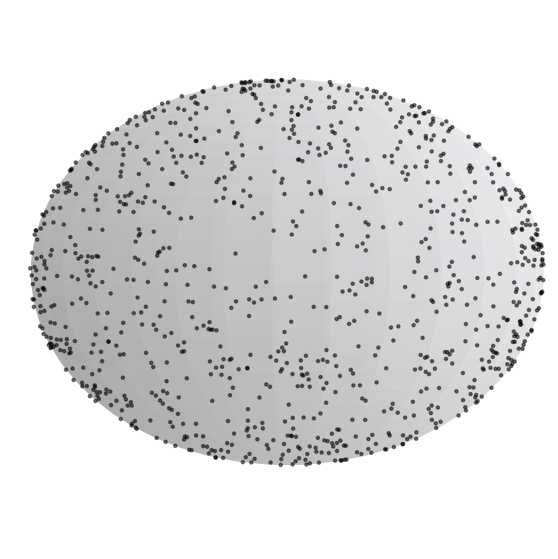

In [2]:
nb = 1000
data = np.random.normal(size=(nb,3))
data = data / np.linalg.norm(data,axis=1).reshape(nb,1)

print(data.shape)
plt.figure(figsize=(7,7))
el = 0
az = 90
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data ,ax,colour="black",sz=5,alpha=0.5)

We consider the normalized volume of quantile regions, by measuring through the uniform measure. Thus the $y$-axis shall never exceed $1$. 
We emphasize that a crucial feature of the MK depth is that contours are indexed by their probability content, inheriting from the associated quantiles.
This is a desirable feature to interpret the volumes of quantile regions. 

A single scale curve is associated to a single distribution. The faster the curve grows, the greater the dispersion of the data. 

A first application consists in comparing the variance of different distributions. If the scale curve of $\nu_1$ is consistently above the one of $\nu_2$, then $\nu_1$ is more spread out than $\nu_2$.
In the following figure, we verify this for von-Mises Fisher distibution with varying concentration parameter $\kappa$. Indeed, the lower the value of $\kappa$, the more spread out is the underlying distribution, which is well-captured. 


In [6]:
rayons = np.linspace(0,1,20)[:-1] 
range_kappa = [1,2,5,15] 
m1 = np.array([0,0,1])
eps = 0.1

scale_curves = -np.ones((len(range_kappa),len(rayons)))
for i,kappa in enumerate(range_kappa):
    n_samples = 1000
    data = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=kappa, n_samples=n_samples)
    u = functions.Robbins_Monro_Algo_faster(Y=data, eps=eps, gamma= 1, c = 0.51, epoch = 20,l_max=30)

    MeanData = functions.func_GeomMedian(data)
    F_thetaM = functions.Fentropic(MeanData,u,eps)
    
    scale_curves[i] = functions.scale_curve(u,rayons,F_thetaM,eps)


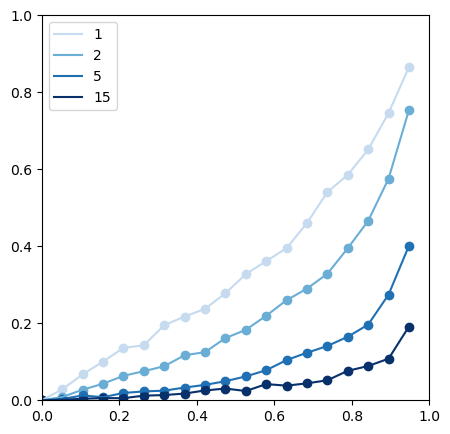

In [7]:
nb_start = 0
nb_end = len(range_kappa)
c = np.arange(1, nb_end-nb_start + 1)
norm = mpl.colors.Normalize(vmin=0, vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues) #Blues or viridis? 
cmap.set_array([])

plt.figure(figsize=(5,5))
# regularized errors for a single choice of parameters (s,eps)
for i in range(nb_start,nb_end):
    df = scale_curves[i] # one error for each rank
    plt.scatter(rayons,df,color=cmap.to_rgba(i + 1))
    plt.plot(rayons,df,label=str(range_kappa[i]),color=cmap.to_rgba(i + 1))

plt.xlim(0,1) 
plt.ylim(0,1) 
plt.legend() 

#  Outliers

<Axes3D: >

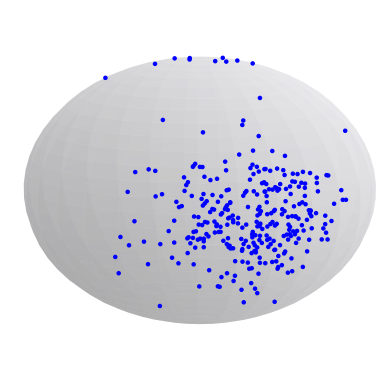

In [11]:

def samplevMF_withoutliers(n_samples,nb_outliers=0):
    ''' Kappa is the skewness intensity'''
    m1 = np.array([0,1,0])
    kappa = 15
    data1 = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=kappa, n_samples=n_samples) 

    data2 = Hypersphere(dim=2).random_von_mises_fisher(mu=np.array([0,0,1]),kappa=30, n_samples=nb_outliers) 

    return(np.concatenate([data1,data2]))

n_samples = 300 
data1 = samplevMF_withoutliers(n_samples,nb_outliers = 10)
#data2,data_test2 = sampleTangentvMF(n_samples,kappa=10)
data3,data_test2 = sampleTangentvMF(n_samples,kappa=50)
#data4,data_test2 = sampleTangentvMF(n_samples,kappa=100)

el = 10
az = 75
ax = functions.def_ax_sphere3D(el,az,sph_alpha=0.3)
functions.plot_3d_scatter(data1 ,ax,colour="blue",sz=5)

In [13]:
rayons = np.linspace(0,1,30)[1:-1] 
range_ = [5,20,50] 
m1 = np.array([0,0,1])
eps = 0.1

scale_curves = -np.ones((len(range_),len(rayons)))
for i,kappa in enumerate(range_):
    n_samples = 500
    data = samplevMF_withoutliers(n_samples,nb_outliers = kappa)
    u = functions.Robbins_Monro_Algo_faster(Y=data, eps=eps, gamma= 1, c = 0.75, epoch = 30,l_max=30)

    MeanData = functions.func_GeomMedian(data)
    F_thetaM = functions.Fentropic2(MeanData,u,eps)
    
    scale_curves[i] = functions.scale_curve(u,rayons,F_thetaM,eps)


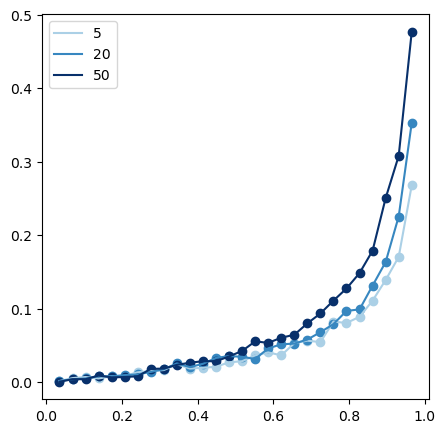

In [14]:
nb_start = 0
nb_end = len(range_)
c = np.arange(1, nb_end-nb_start + 1)
norm = mpl.colors.Normalize(vmin=0, vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues) #Blues or viridis? 
cmap.set_array([])

plt.figure(figsize=(5,5))
# regularized errors for a single choice of parameters (s,eps)
for i in range(nb_start,nb_end):
    df = scale_curves[i] # one error for each rank
    plt.scatter(rayons,df,color=cmap.to_rgba(i + 1))
    plt.plot(rayons,df,label=str(range_[i]),color=cmap.to_rgba(i + 1))


plt.legend()

# Additional experiments, a toy-exampple comparison of vector valued estimators

In the work of Liu, it is used to compare the variance of given vector-valued estimators. Their development is partially reproduced hereafter, for spherical data. 
Consider again a vMF distribution for which the Fréchet mean and median coincide, with concentration parameter $\kappa=2$. 
There, the sample Fréchet mean and median are both estimators of the location parameter $m \in \mathbb{S}^{d-1}$ and one may want to compare their variance, in the way one uses boxplots for comparing real-valued estimators. 
To do so, split data into $N$ subsets. For each $1\leq i \leq N$, compute the sample Fréchet mean $\theta^{\text{Mean}}_i$ and median $\theta^{\text{Med}}_i$.
This yields two distinct distributions of $N$ estimates. 
Our experiment takes $N=100$ subsets of $20$ observations, and uses the entropic map with $\epsilon=0.1$ on the two samples of size $N$. 

The next figure represents the associated scale curves.
As the estimates of Frechet ... are more spread out, one can assess that this estimator is less efficient.  
On a sample of size $30$ from a vMF with $\kappa=2$, the estimates may be inaccurate.




In [6]:
N = 100 # number of subsets 
nb = 10 # number of points by subset 
kappa = 1
EstimatesMean = -np.ones((N,3))  
EstimatesMed = -np.ones((N,3)) 
for k in range(N): 
    data = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=kappa, n_samples=nb) 
    EstimatesMean[k] = functions.func_Frechetmean(data)
    data = Hypersphere(dim=2).random_von_mises_fisher(mu=m1,kappa=kappa, n_samples=nb) 
    EstimatesMed[k] = functions.func_GeomMedian(data)

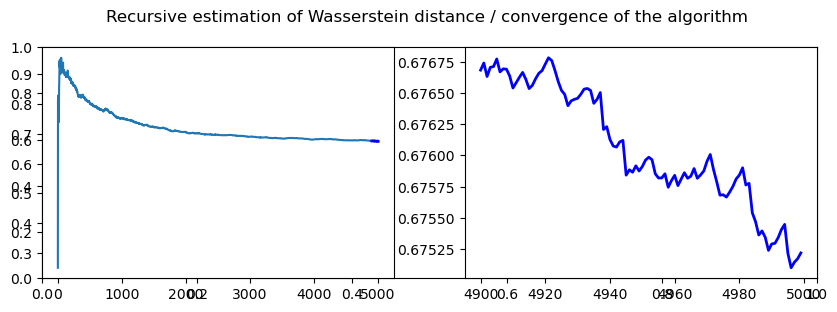

In [8]:
u1,hat_W = functions.Robbins_Monro_Algo(Y=EstimatesMean, eps=0.1, gamma= 1, c = 0.51, epoch = 50,l_max=30)

n_iter = N*50 
plt.figure(figsize=(10,3))
plt.title("Recursive estimation of Wasserstein distance / convergence of the algorithm \n")
plt.subplot(1,2,1)
plt.plot(np.arange(n_iter),hat_W)
n_start = N*(50-1)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

plt.subplot(1,2,2)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

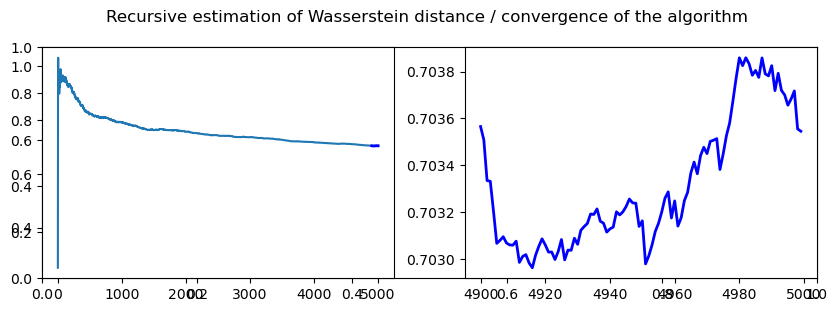

In [9]:
u2,hat_W = functions.Robbins_Monro_Algo(Y=EstimatesMed, eps=0.1, gamma= 1, c = 0.51, epoch = 50,l_max=30)

n_iter = N*50 
plt.figure(figsize=(10,3))
plt.title("Recursive estimation of Wasserstein distance / convergence of the algorithm \n")
plt.subplot(1,2,1)
plt.plot(np.arange(n_iter),hat_W)
n_start = N*(50-1)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

plt.subplot(1,2,2)
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

In [12]:
rayons = np.linspace(0,1,20)[1:-1]

MeanData1 = functions.func_GeomMedian(EstimatesMean)
F_thetaM1 = functions.Fentropic(MeanData1,u1,eps)

MeanData2 = functions.func_GeomMedian(EstimatesMed)
F_thetaM2 = functions.Fentropic(MeanData2,u2,eps)

df1 = functions.scale_curve(u1,rayons,F_thetaM1,eps)  # mean 
df2 = functions.scale_curve(u2,rayons,F_thetaM2,eps)  # med 

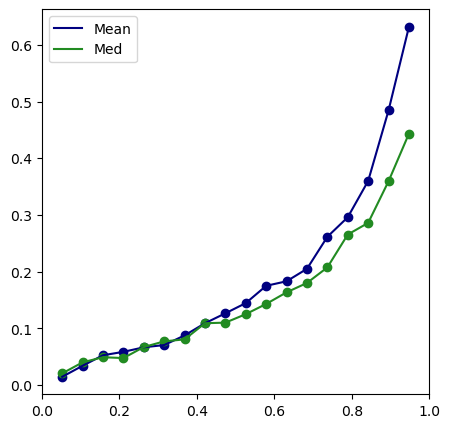

In [13]:
plt.figure(figsize=(5,5))

plt.scatter(rayons,df1,color="navy")
plt.plot(rayons,df1,label="Mean",color="navy")

plt.scatter(rayons,df2,color="forestgreen")
plt.plot(rayons,df2,label="Med",color="forestgreen")

plt.xlim(0,1)
plt.legend()